In [1]:
import os
import platform
import pandas as pd
import tensorflow as tf

from modules.dataset_utils import DatasetUtils as dataset
from tensorflow import keras
from datetime import datetime
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


#########################################################################################################################################################
# PARAMETROS DEFINIDOS EN FUNCION DEL USUARIO
#########################################################################################################################################################

# Ruta hacia los CSV del dataset
train_file_relative = './data/700Train.csv'
validation_file_relative = './data/700Validation.csv'
test_file_relative = './data/700Test.csv'

# Ruta al directorio de imágenes con máscara aplicada
masked_dir_relative = '../local/output_masked/'

model_dir_relative = "./models"

# Ruta relativa hacia la librería ai4eutils
ai4eutils_relative = "./repos/ai4eutils"

# Ruta relativa hacia la librería CameraTraps
CameraTraps_relative = "./repos/CameraTraps"

#########################################################################################################################################################
# PARAMETROS PARA CNN
#########################################################################################################################################################

IMG_HEIGHT = IMG_WEIGHT = 500
EPOCHS = 50
BATCH_SIZE = 16
#########################################################################################################################################################
#########################################################################################################################################################

home = os.path.expanduser("~")

ai4utils = os.path.abspath(ai4eutils_relative)
CameraTraps = os.path.abspath(CameraTraps_relative)
train_file = os.path.abspath(train_file_relative)
validation_file = os.path.abspath(validation_file_relative)
test_file = os.path.abspath(test_file_relative)
masked_dir = os.path.abspath(masked_dir_relative)
model_dir = os.path.abspath(model_dir_relative)

try:
    os.environ['PYTHONPATH']
except KeyError:
    os.environ['PYTHONPATH'] = ""
if platform.system() == 'Windows':
    os.environ['PYTHONPATH'] += (";" + ai4utils)
    os.environ['PYTHONPATH'] += (";" + CameraTraps)
else:
    os.environ['PYTHONPATH'] += (":" + ai4utils)
    os.environ['PYTHONPATH'] += (":" + CameraTraps)

print('=======================================================================================================================================')
print('PYTHONPATH: ' + os.environ['PYTHONPATH'])
print('')
print('ai4eutils PATH: ' + '\t' + ai4utils)
print('CameraTraps PATH: ' + '\t' + CameraTraps)
print('Train CSV PATH: ' + '\t'  + train_file)
print('Validation CSV PATH: ' + '\t' + validation_file)
print('Test CSV PATH: ' + '\t' + '\t' + test_file)
print('masked PATH: ' + '\t' + '\t' + masked_dir)
print('models PATH: ' + '\t' + '\t' + model_dir)
print('=======================================================================================================================================')


TensorFlow version: 2.9.2
Is GPU available? tf.test.is_gpu_available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

PYTHONPATH: /Users/carlos/.vscode/extensions/ms-toolsai.jupyter-2022.6.1201981810/pythonFiles:/Users/carlos/.vscode/extensions/ms-toolsai.jupyter-2022.6.1201981810/pythonFiles/lib/python:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils:/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps

ai4eutils PATH: 	/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/ai4eutils
CameraTraps PATH: 	/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/repos/CameraTraps
Train CSV PATH: 	/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Train.csv
Validation CSV PATH: 	/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Validation.csv
Test CSV PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/data/700Test.csv
masked PATH: 		/Users/carlos/WORKSPACE/local/output_masked
models PATH: 		/Users/carlos/WORKSPACE/TFG-DeteccionF

In [2]:
file_path, labels = dataset.load_dataset(train_file, masked_dir)
TRAIN_BUFFER = len(labels)
train_dataset = tf.data.Dataset.from_tensor_slices((file_path, labels))
train_dataset = train_dataset.map(dataset.load_image).map(dataset.normalize_images).map(dataset.resize_image).shuffle(TRAIN_BUFFER).batch(BATCH_SIZE)

file_path, labels = dataset.load_dataset(validation_file, masked_dir)
VALIDATION_BUFFER = len(labels)
validation_dataset = tf.data.Dataset.from_tensor_slices((file_path, labels))
validation_dataset = validation_dataset.map(dataset.load_image).map(dataset.normalize_images).map(dataset.resize_image).shuffle(VALIDATION_BUFFER).batch(BATCH_SIZE)

file_path, labels = dataset.load_dataset(test_file, masked_dir)
TEST_BUFFER = len(labels)
test_dataset = tf.data.Dataset.from_tensor_slices((file_path, labels))
test_dataset = test_dataset.map(dataset.load_image).map(dataset.normalize_images).map(dataset.resize_image).shuffle(TEST_BUFFER).batch(BATCH_SIZE)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-29 11:39:05.958624: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-29 11:39:05.958729: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
model = keras.Sequential([
    
    layers.Conv2D(16, kernel_size=3, padding='same', activation=tf.nn.relu, input_shape=(IMG_HEIGHT, IMG_WEIGHT, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, kernel_size=3, padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, kernel_size=3, padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, kernel_size=3, padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(16, kernel_size=3, padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D(2,2),

    # Full conected
    layers.Flatten(),
    layers.Dense(1024, kernel_regularizer=keras.regularizers.l2(1e-3), activation=tf.nn.relu),
    layers.Dropout(0.5),
    layers.Dense(1024, kernel_regularizer=keras.regularizers.l2(1e-3), activation=tf.nn.relu),
    layers.Dropout(0.5),

    # Capa de salida
    layers.Dense(1, activation=tf.nn.sigmoid)
])

In [4]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-5),
    loss = [keras.losses.BinaryCrossentropy()],
    metrics =  ['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 500, 500, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 250, 250, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 64)       0

In [5]:
hist = model.fit(
            train_dataset, 
            epochs=EPOCHS,
            validation_data=validation_dataset,
            batch_size=BATCH_SIZE
)

Epoch 1/50


2022-07-29 11:39:06.738396: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-29 11:39:06.738574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - ETA: 0s - loss: 3.2256 - accuracy: 0.6634

2022-07-29 11:39:32.771237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 29s 262ms/step - loss: 3.2256 - accuracy: 0.6634 - val_loss: 3.1392 - val_accuracy: 0.6603
Epoch 2/50
91/91 [==============================] - 28s 260ms/step - loss: 3.0429 - accuracy: 0.6628 - val_loss: 2.9553 - val_accuracy: 0.6603
Epoch 3/50
91/91 [==============================] - 28s 261ms/step - loss: 2.8835 - accuracy: 0.6628 - val_loss: 2.8173 - val_accuracy: 0.6603
Epoch 4/50
91/91 [==============================] - 28s 259ms/step - loss: 2.7552 - accuracy: 0.6628 - val_loss: 2.6980 - val_accuracy: 0.6603
Epoch 5/50
91/91 [==============================] - 28s 259ms/step - loss: 2.6385 - accuracy: 0.6628 - val_loss: 2.5834 - val_accuracy: 0.6603
Epoch 6/50
91/91 [==============================] - 28s 260ms/step - loss: 2.5250 - accuracy: 0.6628 - val_loss: 2.4745 - val_accuracy: 0.6603
Epoch 7/50
91/91 [==============================] - 28s 259ms/step - loss: 2.4211 - accuracy: 0.6628 - val_loss: 2.3743 - val_accuracy: 0.6603
Epoch 8/50

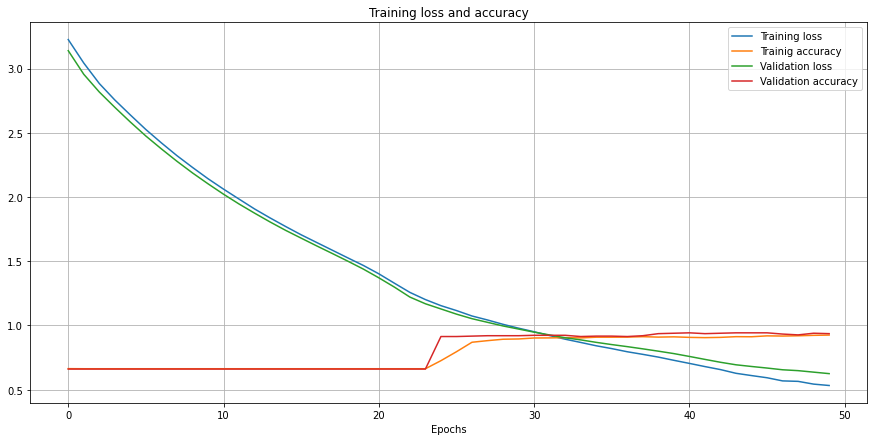

In [6]:
ax = pd.DataFrame(data=hist.history).plot(figsize=(15, 7))
ax.grid()
_ = ax.set(title="Training loss and accuracy", xlabel="Epochs")
_ = ax.legend(["Training loss", "Trainig accuracy", "Validation loss", "Validation accuracy"])

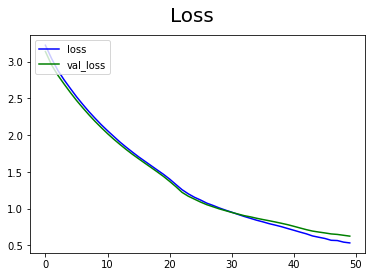

In [13]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss', )
plt.plot(hist.history['val_loss'], color='green', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

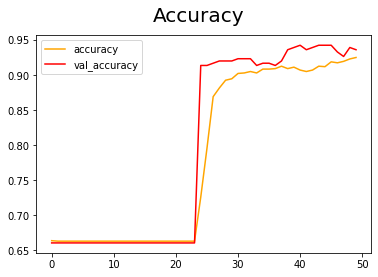

In [8]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='orange', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [9]:
results = model.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 2s 73ms/step - loss: 0.5406 - accuracy: 0.9228


In [10]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for sample in test_dataset: 
    X = sample[0]
    y = sample[1]
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print('Precision: ' + str(pre.result()))
print('Recall: ' + str(re.result()))
print('BinaryAccuracy: ' + str(acc.result()))

1/1 [==============================] - 0s 21ms/step


2022-07-29 12:02:35.988623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 46ms/step
Precision: tf.Tensor(0.959596, shape=(), dtype=float32)
Recall: tf.Tensor(0.9223301, shape=(), dtype=float32)
BinaryAccuracy: tf.Tensor(0.92282957, shape=(), dtype=float32)


In [11]:
date = datetime.utcnow().strftime('%Y-%m-%d_%H-%M')
if platform.system() == 'Windows':
    path = model_dir + '\\'+ date
else:
    path = model_dir + '/'+ date

model.save(path)

INFO:tensorflow:Assets written to: /Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/models/2022-07-29_10-02/assets


INFO:tensorflow:Assets written to: /Users/carlos/WORKSPACE/TFG-DeteccionFototrampeo/models/2022-07-29_10-02/assets
